# Introduction

In this notebook a Bag of Words approach will be implemented to classify customers based on their review.

Some useful functions will be implemented 
to pre-process the text, they help a lot in the algorithms performance and are essential in this kind of application.

# Importing Libraries


In [ ]:
import pandas as pd
import numpy as np

! python -m spacy download en_core_web_md
import spacy
spacy.prefer_gpu()

from sklearn.model_selection import train_test_split

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.naive_bayes import MultinomialNB
import xgboost as xgb
from sklearn import svm

from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import f1_score

import matplotlib.pyplot as plt

import warnings; warnings.simplefilter('ignore')

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_md')


# Functions

In [ ]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="black" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="black" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

In [ ]:
def show_confusion_matrix(y_train_true,y_val_true,y_test_true,y_pred_train,y_pred_val,y_pred_test):
    true = [y_train_true,y_val_true,y_test_true]
    pred = [y_pred_train,y_pred_val,y_pred_test]
    for i in range(3):
        plot_confusion_matrix(confusion_matrix(true[i], pred[i]),target_names = ['N-Recommended','Recommended'],
                              title=print('F1_score de: {}%'.format(
                                  round(f1_score(true[i],pred[i])*100,4))),cmap=None,normalize=True)

In [ ]:
def flatten(lst):
    new_lst = []
    flatten_helper(lst, new_lst)
    return new_lst
 
def flatten_helper(lst, new_lst):
    for element in lst:
        if isinstance(element, list):
            flatten_helper(element, new_lst)
        else:
            new_lst.append(element)

In [ ]:
def RemoveSmallWords(Series):
    t = Series.str.split(expand=True).stack()
    return t.loc[t.str.len() >= 4].groupby(level=0).apply(' '.join)

In [ ]:
def TextPreProcessing (df,text_column):
  df.loc[df[text_column].isna(),text_column] = '-EMPTY-'
  # Creating Corpus with Spacy pipe.
  nlp = spacy.load('en_core_web_md')
  corpus = list(nlp.pipe(df[text_column]))
  a_lemmas = []
  for i in range(len(corpus)):
    try:
      #creating name entity recognition list for the especific corpus
      ents = [ent.text.split() for ent in corpus[i].ents]
      ents = flatten(ents)    
      # Tokenization with lemmatizer
      lemmas = [token.lemma_ for token in corpus[i]]
      # Removing non-alphabetic characters
      a_lemmas.append(pd.Series([lemma for lemma in lemmas if (lemma.isalpha() and nlp.vocab[lemma].is_stop==False)])) 
      a_lemmas[i] = a_lemmas[i][~a_lemmas[i].isin(pd.Series(ents))]
      a_lemmas[i] = RemoveSmallWords(a_lemmas[i])
      a_lemmas[i].reset_index(inplace = True, drop = True)
    except:
      a_lemmas[i] = '-EMPTY-'
    a_lemmas[i] = ' '.join(a_lemmas[i])
  df[text_column] = a_lemmas
  return df

# Importing Data

In [ ]:
df = pd.read_csv('/content/drive/My Drive/ML Projects/Womens Clothing E-Commerce/Womens Clothing E-Commerce Reviews.csv')
df

,Unnamed: 0,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses
...,...,...,...,...,...,...,...,...,...,...,...
23481,23481,1104,34,Great dress for many occasions,I was very happy to snag this dress at such a ...,5,1,0,General Petite,Dresses,Dresses
23482,23482,862,48,Wish it was made of cotton,"It reminds me of maternity clothes. soft, stre...",3,1,0,General Petite,Tops,Knits
23483,23483,1104,31,"Cute, but see through","This fit well, but the top was very see throug...",3,0,1,General Petite,Dresses,Dresses
23484,23484,1084,28,"Very cute dress, perfect for summer parties an...",I bought this dress for a wedding i have this ...,3,1,2,General,Dresses,Dresses


# Spliting Data

In [ ]:
train, test = train_test_split(df,test_size = 0.3,random_state=7)
test, val = train_test_split(test,test_size=0.5,random_state=7)

train.reset_index(inplace = True)
val.reset_index(inplace = True)
test.reset_index(inplace = True)

print(train.shape)
print(val.shape)
print(test.shape)

(16440, 12)
(3523, 12)
(3523, 12)


# Text Pre-Processing

In [ ]:
train_review = TextPreProcessing (df = train,text_column = 'Review Text')
val_review = TextPreProcessing (df = val,text_column = 'Review Text')
test_review = TextPreProcessing (df = test,text_column = 'Review Text')

## TF-IDF

In [ ]:
tfidf_vectorizer = TfidfVectorizer()

bow_train = tfidf_vectorizer.fit_transform(train_review['Review Text'])
bow_val = tfidf_vectorizer.transform(val_review['Review Text'])
bow_test = tfidf_vectorizer.transform(test_review['Review Text'])

# Classfication

## Naive Bayes

In [ ]:
nb = MultinomialNB()
nb.fit(bow_train,train['Recommended IND'])

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [ ]:
train_pred = nb.predict(bow_train)
val_pred = nb.predict(bow_val)
test_pred = nb.predict(bow_test)

print(f1_score(train['Recommended IND'],train_pred))
print(f1_score(val['Recommended IND'],val_pred))
print(f1_score(test['Recommended IND'],test_pred))

0.9114813938554095
0.9088635297795841
0.9093179335102232


F1_score de: 91.1481%


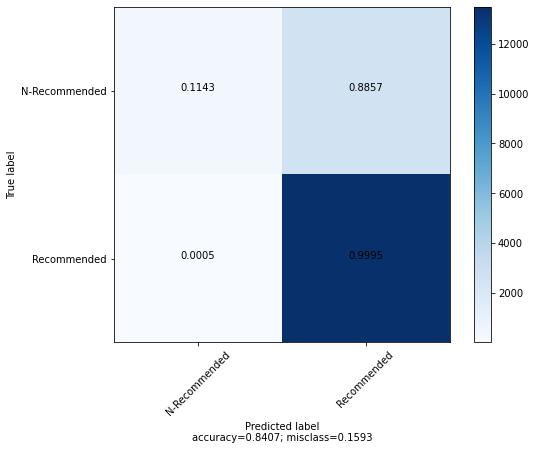

F1_score de: 90.8864%


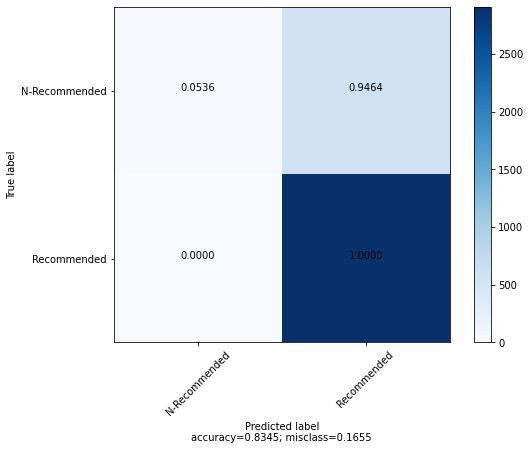

F1_score de: 90.9318%


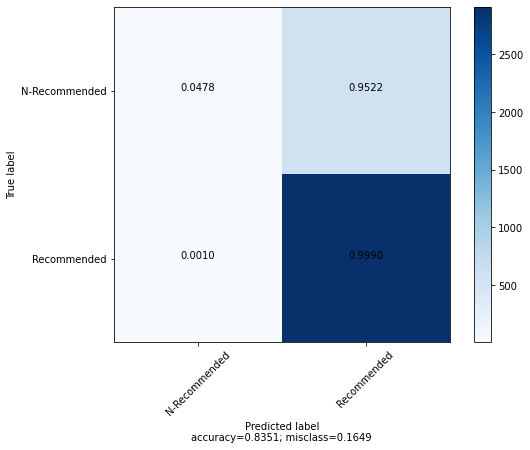

In [ ]:
show_confusion_matrix(train['Recommended IND'],val['Recommended IND'],test['Recommended IND'],train_pred,val_pred,
                      test_pred)

## SVM

In [ ]:
svm_clf = svm.SVC()
svm_clf.fit(bow_train,train['Recommended IND'])

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [ ]:
train_pred = svm_clf.predict(bow_train)
val_pred = svm_clf.predict(bow_val)
test_pred = svm_clf.predict(bow_test)

print(f1_score(train['Recommended IND'],train_pred))
print(f1_score(val['Recommended IND'],val_pred))
print(f1_score(test['Recommended IND'],test_pred))

0.981936284348429
0.9317507418397627
0.9287356321839081


F1_score de: 98.1936%


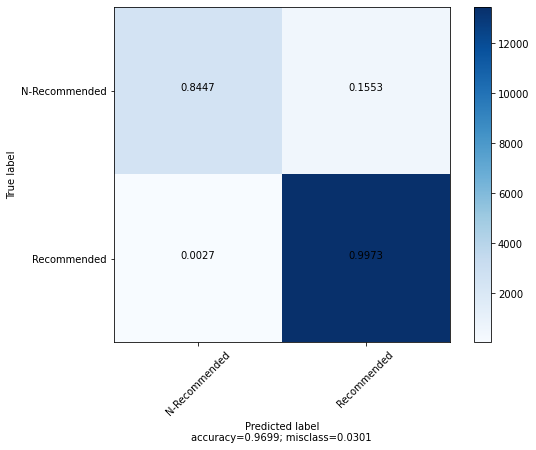

F1_score de: 93.1751%


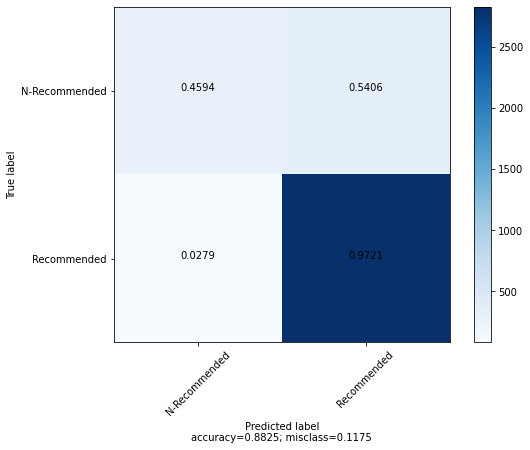

F1_score de: 92.8736%


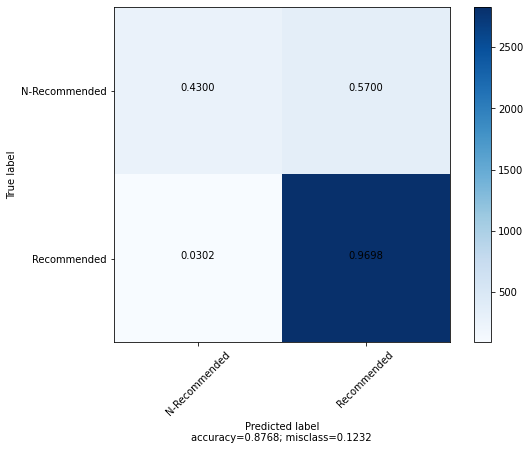

In [ ]:
show_confusion_matrix(train['Recommended IND'],val['Recommended IND'],test['Recommended IND'],train_pred,val_pred,
                      test_pred)

## XGBoost

In [ ]:
xgb_clf = xgb.XGBClassifier(learning_rate = 0.01,
                         max_depth = 10, 
                         n_estimators = 1000,
                         objective = 'binary:logistic',
                         verbosity =0,
                         seed = 42,
                         reg_lambda = 8,
                         reg_alpha = 2,
                         gamma = 5,
                         subsample= 0.8,
                         tree_method = 'gpu_hist')
xgb_clf.fit(bow_train,train['Recommended IND'])

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=5,
              learning_rate=0.01, max_delta_step=0, max_depth=10,
              min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=2, reg_lambda=8, scale_pos_weight=1, seed=42,
              silent=None, subsample=0.8, tree_method='gpu_hist', verbosity=0)

In [ ]:
train_pred = xgb_clf.predict(bow_train)
val_pred = xgb_clf.predict(bow_val)
test_pred = xgb_clf.predict(bow_test)

print(f1_score(train['Recommended IND'],train_pred))
print(f1_score(val['Recommended IND'],val_pred))
print(f1_score(test['Recommended IND'],test_pred))

0.9467111331866884
0.9259563290100148
0.9222747270653414


F1_score de: 94.6711%


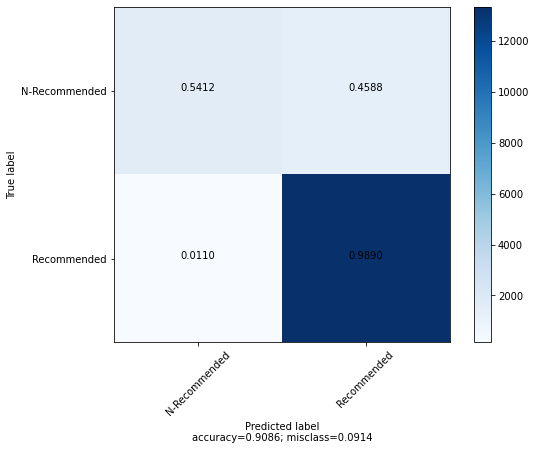

F1_score de: 92.5956%


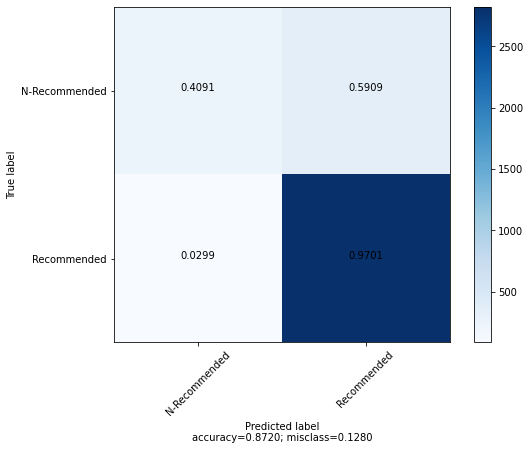

F1_score de: 92.2275%


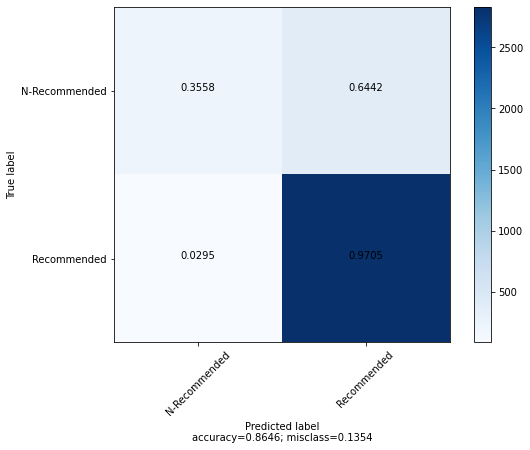

In [ ]:
show_confusion_matrix(train['Recommended IND'],val['Recommended IND'],test['Recommended IND'],train_pred,val_pred,
                      test_pred)




# Conclusion

SVM performe a little bit better than the others algorithm, however the imbalanced rate at the target column it's decreasing the performance, in the next notebook this problem will be solve.   